## 01. Generating a synthetic .LAS file and Creating Well Data in a CSV file

#### Keith R. Holdaway

In [2]:
import lasio
import numpy as np

# Create synthetic well log data
np.random.seed(42)
depth = np.arange(1000, 12000, 0.5)  # 1000-12000 ft at 0.5 ft intervals
n_samples = len(depth)

# Generate realistic-looking logs with some formation changes
def make_log(pattern, noise_level=0.1):
    return pattern + np.random.normal(0, noise_level, n_samples)

# Create log patterns
gr_pattern = np.clip(50 + 30*np.sin((depth-1000)/100) + 
                    np.where((depth>1400)&(depth<1600), 40, 0), 0, 150)
rt_pattern = np.exp(2 + 0.8*np.sin((depth-1000)/80) - 
                  0.5*np.where((depth>1200)&(depth<1500), 1, 0))
nphi_pattern = np.clip(0.15 + 0.1*np.cos((depth-1000)/120) - 
                     0.05*np.where((depth>1300)&(depth<1700), 1, 0), 0.01, 0.4)
rhob_pattern = 2.65 - 0.8*nphi_pattern + 0.1*np.random.normal(0, 1, n_samples)
dt_pattern = 55 + (depth-1000)*0.02 + 20*nphi_pattern

# Generate logs with noise
gr = make_log(gr_pattern, 5)        # gamma radiation emitted by subsurface formations 
rt = make_log(rt_pattern, 0.2)      # electrical well logs that record the resistivity of a formation
nphi = make_log(nphi_pattern, 0.02) # assess the porosity of subsurface formations
rhob = make_log(rhob_pattern, 0.05) # determine lithology, porosity, and fluid saturation
dt = make_log(dt_pattern, 2)        # measure the travel time of sound waves through rocks



####   - Shale: high GR (e.g., 80-140 API)
####   - Sandstone: low GR (e.g., 20-40 API)
####   - Limestone: medium GR (e.g., 30-60 API)
####   - Anomaly (e.g., uranium-rich zone): very high GR

In [3]:
# Create LAS file
las = lasio.LASFile()

# Add header information
las.well['WELL'] = 'SYNTHETIC'
las.well['FLD'] = 'TEST FIELD'
las.well['LOC'] = '00-000-00000'
las.well['SRVC'] = 'SYNTHETIC LOGS'
las.well['DATE'] = '2023-01-01'
las.well['STRT'] = depth[0]
las.well['STOP'] = depth[-1]
las.well['STEP'] = 0.5
las.well['NULL'] = -999.25

# Add curve information
las.append_curve('DEPT', depth, unit='ft', descr='Depth')
las.append_curve('GR', gr, unit='API', descr='Gamma Ray')
las.append_curve('RT', rt, unit='OHMM', descr='Resistivity')
las.append_curve('NPHI', nphi, unit='V/V', descr='Neutron Porosity')
las.append_curve('RHOB', rhob, unit='G/CC', descr='Bulk Density')
las.append_curve('DT', dt, unit='US/F', descr='Sonic Travel Time')

# Add parameter section
las.params['MDATE'] = lasio.HeaderItem('MDATE', value='2023-01-01', descr='Logging Date')
las.params['EREF'] = lasio.HeaderItem('EREF', value=1000, unit='ft', descr='Elevation Reference')

# Write to file
las.write('synthetic_well_logs.las', version=2.0)

print("Successfully created synthetic_well_logs.las")

Successfully created synthetic_well_logs.las


In [4]:
# Create a .cvs file from generated .las

In [5]:
import pandas as pd

def las_to_csv(las_file_path, csv_file_path):
    """
    Convert a LAS file to CSV format and save it.
    
    Parameters:
        las_file_path (str): Path to the input LAS file
        csv_file_path (str): Path where the output CSV will be saved
    """
    try:
        # Read the LAS file using lasio library
        import lasio
        las = lasio.read(las_file_path)
        
        # Convert to pandas DataFrame
        df = las.df()
        
        # Add depth column (index is typically depth in LAS files)
        df.reset_index(inplace=True)
        df.rename(columns={'DEPT': 'DEPTH'}, inplace=True)
        
        # Save to CSV
        df.to_csv(csv_file_path, index=False)
        print(f"Successfully converted {las_file_path} to {csv_file_path}")
        
    except ImportError:
        print("Error: lasio library not found. Please install it with: pip install lasio")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Example usage
if __name__ == "__main__":
    input_las = "synthetic_well_logs.las"   # Replace with your LAS file path
    output_csv = "synthetic_well_logs.csv"  # Replace with desired CSV output path
    las_to_csv(input_las, output_csv)

Successfully converted synthetic_well_logs.las to synthetic_well_logs.csv


#### Enhanced code that adds VSH (Shale Volume) and SW (Water Saturation) calculations to your synthetic LAS file generation:

In [ ]:
import lasio
import numpy as np
import matplotlib.pyplot as plt

# Create synthetic well log data
np.random.seed(42)
depth = np.arange(1000, 12000, 0.5)  # 1000-12000 ft at 0.5 ft intervals
n_samples = len(depth)

# Generate realistic-looking logs with some formation changes
def make_log(pattern, noise_level=0.1):
    return pattern + np.random.normal(0, noise_level, n_samples)

# Create log patterns
gr_pattern = np.clip(50 + 30*np.sin((depth-1000)/100) + 
                    np.where((depth>1400)&(depth<1600), 40, 0), 0, 150)
rt_pattern = np.exp(2 + 0.8*np.sin((depth-1000)/80) - 
                  0.5*np.where((depth>1200)&(depth<1500), 1, 0))
nphi_pattern = np.clip(0.15 + 0.1*np.cos((depth-1000)/120) - 
                     0.05*np.where((depth>1300)&(depth<1700), 1, 0), 0.01, 0.4)
rhob_pattern = 2.65 - 0.8*nphi_pattern + 0.1*np.random.normal(0, 1, n_samples)
dt_pattern = 55 + (depth-1000)*0.02 + 20*nphi_pattern

# Generate logs with noise
gr = make_log(gr_pattern, 5)
rt = make_log(rt_pattern, 0.2)
nphi = make_log(nphi_pattern, 0.02)
rhob = make_log(rhob_pattern, 0.05)
dt = make_log(dt_pattern, 2)

# Calculate VSH (Shale Volume) - Linear GR method
gr_clean = 30  # API in clean zone
gr_shale = 120  # API in shale zone
vsh = np.clip((gr - gr_clean) / (gr_shale - gr_clean), 0, 1)

# Calculate SW (Water Saturation) - Archie's equation
a = 1.0   # Tortuosity factor
m = 2.0   # Cementation exponent
n = 2.0   # Saturation exponent
rw = 0.1  # Ohm-m @ formation temperature

phi = nphi  # Using neutron porosity for this example
sw = np.clip((a * rw / (phi**m * rt)) ** (1/n), 0.01, 1.0)

# Create LAS file
las = lasio.LASFile()
las.well['WELL'].value = 'SYNTHETIC'
las.well['STRT'].value = depth[0]
las.well['STOP'].value = depth[-1]
las.well['STEP'].value = 0.5

las.append_curve('DEPT', depth, unit='ft', descr='Depth')
las.append_curve('GR', gr, unit='API', descr='Gamma Ray')
las.append_curve('RT', rt, unit='OHMM', descr='Resistivity')
las.append_curve('NPHI', nphi, unit='V/V', descr='Neutron Porosity')
las.append_curve('RHOB', rhob, unit='G/CC', descr='Bulk Density')
las.append_curve('DT', dt, unit='US/FT', descr='Sonic Transit Time')
las.append_curve('VSH', vsh, unit='V/V', descr='Shale Volume')
las.append_curve('SW', sw, unit='V/V', descr='Water Saturation')

# Save LAS file
las.write('synthetic_well_Sw_Vsh.las')

# Visualize the results
fig, ax = plt.subplots(1, 6, figsize=(18, 12), sharey=True)
fig.suptitle('Synthetic Well Logs with VSH and SW', fontsize=16)

# Track 1: GR and VSH
ax[0].plot(gr, depth, 'g', label='GR')
ax[0].plot(vsh*150, depth, 'b', label='VSH (scaled)')
ax[0].set_xlabel('GR [API] / VSH [scaled]')
ax[0].legend()

# Track 2: Resistivity
ax[1].semilogx(rt, depth, 'r')
ax[1].set_xlabel('RT [ohm-m]')

# Track 3: Porosity
ax[2].plot(nphi*100, depth, 'm', label='NPHI')
ax[2].plot(rhob, depth, 'k', label='RHOB')
ax[2].set_xlabel('NPHI [%] / RHOB [g/cc]')
ax[2].legend()

# Track 4: Sonic
ax[3].plot(dt, depth, 'c')
ax[3].set_xlabel('DT [μs/ft]')

# Track 5: Water Saturation
ax[4].plot(sw*100, depth, 'b')
ax[4].set_xlabel('SW [%]')

# Track 6: Lithology
ax[5].fill_betweenx(depth, 0, vsh*100, color='brown', alpha=0.3, label='Shale')
ax[5].fill_betweenx(depth, vsh*100, 100, color='yellow', alpha=0.3, label='Sand')
ax[5].set_xlabel('Lithology [type]')
ax[5].legend()

for a in ax:
    a.grid(True)
    a.set_ylim(12000, 1000)  # Reverse depth scale

plt.tight_layout()
plt.show()

### Key additions:

#### VSH Calculation:

Uses linear GR method between clean (30 API) and shale (120 API) endpoints

Clipped to 0-1 range for physical consistency

#### SW Calculation:

Implements Archie's equation with standard parameters

Includes porosity (NPHI) and resistivity (RT) inputs

Clipped to 1-100% range

#### Visualization:

Added SW and VSH tracks to log display

Includes lithology track showing sand/shale distribution

All tracks are depth-aligned

#### LAS File Output:

Now includes VSH and SW curves in the output file

Proper units and descriptions for all curves

### Formations:
      1000-1200: Sandstone (low GR) with a baseline of 30 API, plus some noise and a thin shale layer in the middle
      1200-1400: Shale (high GR) with baseline 100 API
      1400-1600: Limestone (medium GR) with baseline 50 API
      1600-1800: Sandstone again, but with a decreasing trend and an anomaly (uranium) at 1700-1720
      1800-2000: Shale with increasing trend

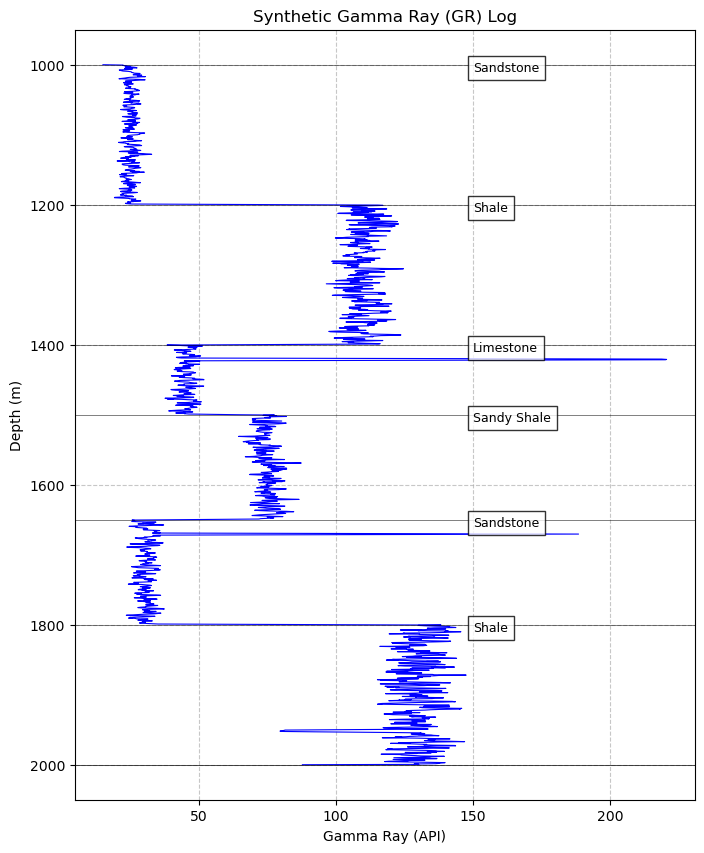

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
depth_start = 1000  # meters (MD)
depth_end = 2000
depth_step = 0.5    # 0.5m sampling rate
depth = np.arange(depth_start, depth_end + depth_step, depth_step)

# Initialize GR array
gr = np.zeros_like(depth)

# Define formations with typical API ranges
formations = [
    {"top": 1000, "base": 1200, "type": "Sandstone", "base_gr": 25, "variation": 5},
    {"top": 1200, "base": 1400, "type": "Shale", "base_gr": 110, "variation": 15},
    {"top": 1400, "base": 1500, "type": "Limestone", "base_gr": 45, "variation": 8},
    {"top": 1500, "base": 1650, "type": "Sandy Shale", "base_gr": 75, "variation": 10},
    {"top": 1650, "base": 1800, "type": "Sandstone", "base_gr": 30, "variation": 7},
    {"top": 1800, "base": 2000, "type": "Shale", "base_gr": 130, "variation": 20}
]

# Add special features
anomalies = [
    {"depth": 1420, "width": 2, "intensity": 220},  # Hot shale streak
    {"depth": 1670, "width": 1, "intensity": 190},  # Uranium anomaly
    {"depth": 1950, "width": 3, "intensity": 80}    # Clean sand lens
]

# Generate baseline log
for formation in formations:
    mask = (depth >= formation["top"]) & (depth <= formation["base"])
    gr[mask] = formation["base_gr"]
    
    # Add formation variability
    gr[mask] += np.random.uniform(
        -formation["variation"],
        formation["variation"],
        size=np.sum(mask)
    )

# Add anomalies
for anomaly in anomalies:
    anomaly_mask = (depth >= anomaly["depth"]) & (depth <= anomaly["depth"] + anomaly["width"])
    gr[anomaly_mask] = anomaly["intensity"]

# Add measurement noise (Gaussian)
noise = np.random.normal(0, 2.5, size=len(depth))  # API units
gr_noisy = gr + noise

# Add tool response smoothing (moving average)
window_size = 3
gr_smooth = np.convolve(gr_noisy, np.ones(window_size)/window_size, mode='same')

# Plot results
plt.figure(figsize=(8, 10))
plt.plot(gr_smooth, depth, 'b-', linewidth=0.8)
plt.gca().invert_yaxis()  # Depth increases downward
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Synthetic Gamma Ray (GR) Log')
plt.xlabel('Gamma Ray (API)')
plt.ylabel('Depth (m)')

# Add formation markers
for formation in formations:
    plt.axhline(y=formation["top"], color='k', linestyle='-', linewidth=0.5, alpha=0.7)
    plt.text(150, formation["top"] + 10, formation["type"], 
             fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

plt.axhline(y=formations[-1]["base"], color='k', linestyle='-', linewidth=0.5)
plt.show()